In [35]:
%matplotlib notebook

import sys
import numpy as np  # Matrix and vector computation package
import sklearn
import sklearn.datasets # To generate the dataset
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib import cm # Colormaps
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)

In [302]:
n_samples = 200

X, t = sklearn.datasets.make_circles(n_samples=n_samples, shuffle=False, factor=0.3, noise=0.16)
T = np.zeros((n_samples, 2))
#cool fora
T[t==1, 1] = 1
T[t==0, 0] = 1
x_red = X[t==0]
x_blue = X[t==1]

<IPython.core.display.Javascript object>


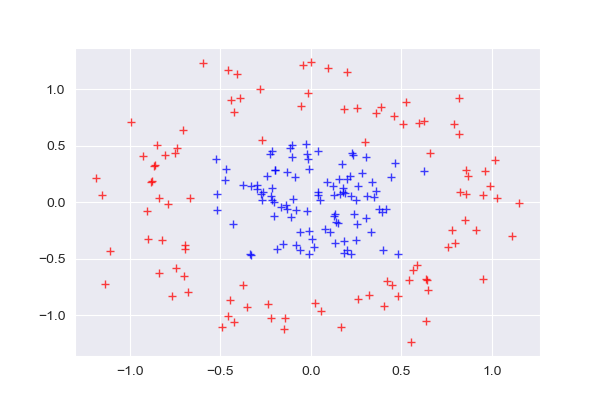

In [303]:
plt.figure(figsize=(6,4))
plt.plot(x_red[:, 0], x_red[:, 1], 'r+', alpha=0.75)
plt.plot(x_blue[:, 0], x_blue[:,1], 'b+', alpha=0.75)

In [304]:
def logistic(z):
    return 1. / (1. + np.exp(-z))

def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

def hidden_activations(X, Wh, bh):
    return logistic((X @ Wh) + bh)

def output_activations(H, Wo, bo):
    return softmax(H.dot(Wo) + bo)

def nn(X, Wh, bh, Wo, bo):
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)

def nn_predict(X, Wh, bh, Wo, bo):
    return np.around(nn(X, Wh, bh, Wo, bo))

def loss(Y, T):
    return -(T * np.log(Y)).sum()

def error_output(Y,T):
    return Y - T

def gradient_weight_out(H, Eo):
    return H.T @ Eo

def gradient_bias_out(Eo):
    return np.sum(Eo, axis=0, keepdims=True)

In [306]:
def error_hidden(H, Wo, Eo):
    """Error at the hidden layer.
    H * (1-H) * (E . Wo^T)"""
    return np.multiply(np.multiply(H,(1 - H)), (Eo @ Wo.T))

def gradient_weight_hidden(X, Eh):
    """Gradient for the weight parameters at the hidden layer"""
    return X.T @ Eh

def gradient_bias_hidden(Eh):
    """Gradient for the bias parameters at the output layer"""
    return  np.sum(Eh, axis=0, keepdims=True)

In [307]:
init_var = 1

bh = np.random.randn(1, 5) * init_var
Wh = np.random.randn(2, 5) * init_var
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(5, 2) * init_var

H = hidden_activations(X, Wh, bh)
Y = output_activations(H, Wo, bo)

Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)
# Compute the gradients of the hidden layer
Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

params = [Wh, bh, Wo, bo]
grad_params = [JWh, Jbh, JWo, Jbo]

eps = 0.0001
length = len(params)
for idx in range(length):
    for row in range(params[idx].shape[0]):
        for col in range(params[idx].shape[1]):
                        
            p_matrix_min = params[idx].copy()
            p_matrix_min[row,col] -= eps
            p_matrix_plus = params[idx].copy()
            p_matrix_plus[row,col] += eps
            # Copy the parameter list, and change the updated 
            
            #  parameter matrix
            params_min = params[:]
            params_min[idx] = p_matrix_min
            params_plus = params[:]
            params_plus[idx] =  p_matrix_plus
            
            grad_num = (
                loss(nn(X, *params_plus), T)-loss(nn(X, *params_min), T)
            ) / (2 * eps)
            if not np.isclose(grad_num, grad_params[idx][row, col]):
                raise ValueError((
                    f'Numerical gradient of {grad_num:.6f} '
                    'is not close to the backpropagation '
                    f'gradient of {grad_params[p_idx][row,col]:.6f}!'))
print('No gradient errors found')

No gradient errors found


In [308]:
#metoda koja azurira gradijente
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    """Update the network parameters over 1 iteration."""
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]

def update_momentum(X, T, ls_of_params, Ms, momentum_term, 
                    learning_rate):
    """Update the momentum term."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    ls = []
    for M,J in zip(Ms,Js):
        ls.append(momentum_term * M - learning_rate * J)
    return ls

def update_params_momentum(ls_of_params, Ms):
    """Update the parameters."""
    # ls_of_params = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    ls = []
    for P,M in zip(ls_of_params, Ms):
        ls.append(P + M)
    return ls

def update_gradient(X, T, ls_of_params, learning_rate):
    Js = backprop_gradients(X, T, *ls_of_params)
    return [P - lr * G for P, G in zip(ls_of_params, Js)]

<IPython.core.display.Javascript object>


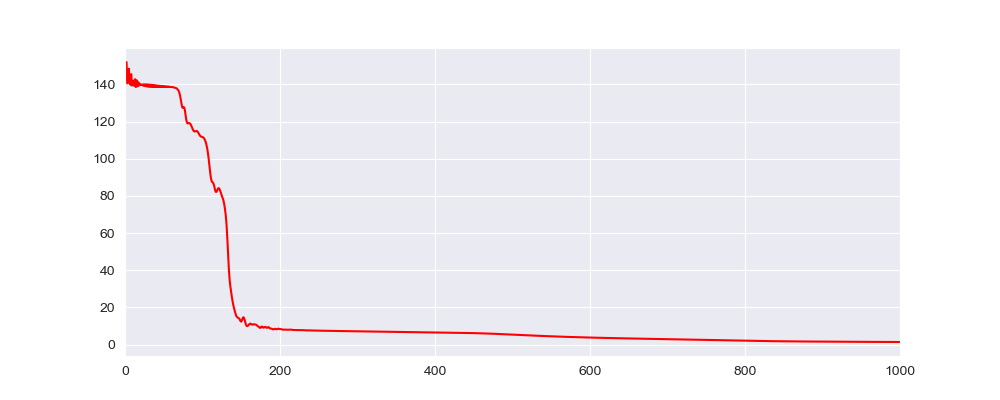

(0.0, 1000.0)

In [310]:
init_var = 0.1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.95

# Moments Ms = [MWh, Mbh, MWo, Mbo]
Ms = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 500*2  # number of gradient descent updates
# learning rate update rule
lr_update = learning_rate / nb_of_iterations
# list of loss over the iterations
ls_loss = [loss(nn(X, Wh, bh, Wo, bo), T)]
for i in range(nb_of_iterations):
    # Update the moments and the parameters
    Ms = update_momentum(
    X, T, [Wh, bh, Wo, bo], Ms, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params_momentum([Wh, bh, Wo, bo], Ms)
    ls_loss.append(loss(nn(X, Wh, bh, Wo, bo), T))
    
fig = plt.figure(figsize=(10,4))
plt.plot(ls_loss, 'r-')
plt.xlim(0, nb_of_iterations)

<IPython.core.display.Javascript object>


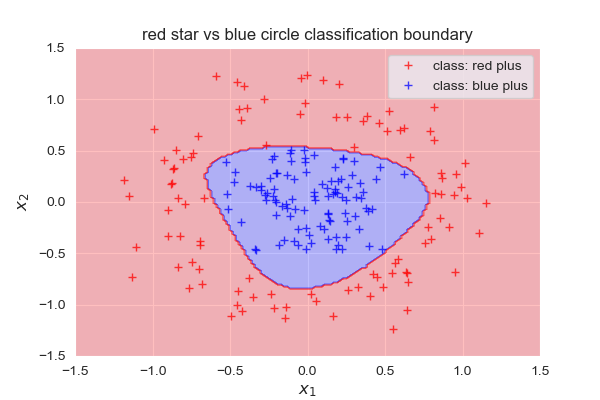

In [311]:
nb_of_xs = 200
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(
            np.asarray([xx[i,j], yy[i,j]]), Wh, bh, Wo, bo)
        classification_plane[i,j] = pred[0, 0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.25),
        colorConverter.to_rgba('r', alpha=0.25)])
plt.figure(figsize=(6, 4))
# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 
         'r+', label='class: red plus', alpha=0.75)
plt.plot(x_blue[:,0], x_blue[:,1], 
         'b+', label='class: blue plus', alpha=0.75)
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=12)
plt.ylabel('$x_2$', fontsize=12)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red star vs blue circle classification boundary')
plt.show()
#